In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from ipywidgets import interact
import time

In [3]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12,4)

# Optomechanics Notebook

In this notebook, we will explore numerical solutions of the optomechanical equations of motion.

We will start by first deriving (or at least writing out) the form of the equations we will implement numerically, both for the full nonlinear parametric coupling, and for the linearized equations of motion valid for small $g_0$ and strong driving. 

We will then simulate various optomechanics experiments using numerical integration. 

## Optomechanical equations of motion

### Full nonlinear parametric coupling

The derivation here will follow the nice section in chapter 2 of the thesis of Frank Buters.

We will consider the case of optomechanics with the following dynamical variables:

* $x$ is the position of the mechanical oscillator
* $a$ is the complex field variable describing the cavity harmonic oscillator

The cavity is driven by an external input field $s_{in}$ via an external coupling rate $\kappa_{ext}$. The mechanics can be driven by external force $F_{ex}(t)$, which could, for example, represent a thermomechanical noise force. 

The equations of motion describing these dynamical variables are: 

\begin{eqnarray}
\frac{da}{dt} & = & \left[ i(\Delta - Gx(t)) -\frac{\kappa}{2} \right] a(t) + 
    \sqrt{\kappa_{ext}} s_{in}(t)\\
\frac{d^2x}{dt^2} & = & -\gamma_m \frac{dx}{dt} - \Omega_m^2 x(t) + 
    \frac{\hbar G}{m}|a(t)|^2 
\end{eqnarray}

Here, $\Delta = \omega_d - \omega_c$ is the detuning of the frequency $\omega_d$ of the external drive field with respect to the natural frequency $\omega_c$ of the cavity. $\gamma_m$ is the mechanical damping rate, $\kappa$ is the total cavity damping rate, and $\Omega_m$ is the natural frequency of the mechanical resoantor. The coupling constant $G$ (the "cavity pull parameter") describes the coupling between the two, and is given by the rate of change of the optical cavity natural frequency with respect to the position of the mechanical resonator:

$$
G = \frac{d \omega_c}{dx}
$$

Note that the in the above equations, we have gone into the "rotating frame" of the drive frequency. In the "lab frame", the field of the cavity $\alpha$ could oscillate at $\omega_c$ and $\omega_d$. Here, we remove the time dependence of the drive field by defining:

$$
\alpha(t) = a(t) e^{i\omega_dt}
$$

In this case, a drive field oscillating at a constant amplitude and phase is described by a constant, time-independent value of $s_{in}$ in these equations.
As usual when solving ODEs, we will split the second order equation for $x$ up into two first order equations: 

\begin{eqnarray}
\frac{da}{dt} & = & \left[ i(\Delta - Gx(t)) -\frac{\kappa}{2} \right] a(t) + 
    \sqrt{\kappa_{ext}} s_{in}(t)\\
\frac{dv}{dt} & = & -\gamma_m \frac{dx}{dt} - \Omega_m^2 x(t) + 
    \frac{\hbar G}{m}|a(t)|^2 \\
\frac{dx}{dt} & = & v
\end{eqnarray}

### Linearized equations

A common approximation is these linearize these equations, an approximation which is valid as long as the cavity is strongly driven: 

$$
s_{in}(t) = s_0
$$



If the cavity is strongly driven, we will first have a ring up to a large average steaday-statte amplitude $\bar a$. In this case we can define a small displacement of the cavity field about the strong, steady-state field amplitude:

$$
a(t) = \bar a + c(t)
$$

In addition, due to the radiation pressure force, the mechanical resonator will experience a static displacement $\bar x$. We will now define the position of the mechanical resonator with respect to its new steady-state average position: 

$$
x(t) = \bar x + u(t)
$$

Using the above equations, we can find the following for $\bar a$ and $\bar x$:

\begin{eqnarray}
\bar a & = & \frac{\sqrt{\kappa_{ext}} s_0}{-i(\Delta+\hbar G x) - \kappa/2} \\
\bar x & = & \frac{\hbar G}{m\Omega_m^2}|\bar a|^2
\end{eqnarray}

Using these with the full EOMs above, and discarding terms second order in $u(t)$ and $c(t)$, we obtain then the linearized EOMs of optomechanics:

\begin{eqnarray}
\frac{dc}{dt} & =  &  \left[ i \tilde \Delta - \frac{\kappa}{2} \right] c(t)  + G \bar a u(t) \\
\frac{d^2u}{dt^2} & = & -\gamma_m \frac{du}{dt} - \Omega_m^2 u(t) + \frac{\hbar G \bar a}{m} [c(t) + c^*(t)] + \frac{F_{ex}(t)}{m}
\end{eqnarray}


where $\tilde \Delta = \Delta  + \hbar G x$. Similar to above, for numerical solutions, we split the second differential equation by defining $v = du / dt$ giving:

\begin{eqnarray}
\frac{dc}{dt} & =  &  \left[ i \tilde \Delta - \frac{\kappa}{2} \right] c(t) + G \bar a u(t) \\
\frac{dv}{dt} & = & -\gamma_m \frac{du}{dt} - \Omega_m^2 u(t) + 
    \frac{\hbar G \bar a}{m} [c(t) + c^*(t)] + \frac{F_{ex}(t)}{m}\\
\frac{du}{dt} & = & v
\end{eqnarray}


## Numerical Integration

### Warm up: only cavity, no mechanics

To warm up, let's start with a simple case of the cavity on it's own (no mechanics yet). 

In OMIT, we have an additional drive tone that is resonant with the cavity. For this, we will have an additional term in the equation for $c$: 

$$
\frac{dc}{dt}  =   \left[ i \tilde \Delta - \frac{\kappa}{2} \right] + G \bar a u(t) + s_{in,pr}(t)
$$

On the red (blue) sideband, this will have the form:

$$
s_{in,pr} = \exp(\pm i \Delta t)
$$

Since we have only one cavity field, we will consider a rotating frame at the frequency of the probe field first to make things very simple. In this case, when resonant with the cavity will not oscillate in time. 

In [171]:
# Our input parameters
kappa = 100e3
Delta_tilde = 0

# Our driving force doens't matter with \bar{a} = 0.
s_in_pr = 1 

# Our input array of driving frequencies
N = 100
w = np.linspace(-2*kappa,2*kappa,N)

# With a first order equation, the vectorisation is simple: just an array. 
# The 0j is needed to make sure solve_ivp knows we are working with a complex
# valued ODE
y0 = np.zeros(N)+0j

# Here, we implement the EOM for c with \bar(a) = 0
def dydt(t,y):
    return (1j*Delta_tilde-kappa/2)*y + s_in_pr*np.exp(1j*w*t)

## Our evaluation times

# The time steps should be short enough to capture the fastest
# oscillations of c so we can analyze the amplitude and phase. 

# At most, c will oscillate at 1/max(np.abs(w)). We should really take 100 time
# steps per oscillation if we want to get good demodulation

dt = 1/max(w)/1000

# What is our maximum time? The ring up of the cavity will occur on a time scale 
# of 1/kappa. To make sure that we reach steady state, we should wait at least 
# 10/kappa

T = 20/kappa
t = np.arange(0,T,dt)
Nt = len(t)
print("Size of time vector: %d" % Nt)

t1 = time.time()
sol = solve_ivp(dydt, [0,T], y0, t_eval = t, method="BDF")
t2 = time.time()
print("Integration time: %.2f s" % (t2-t1))

c = sol.y

Size of time vector: 40000
Integration time: 0.12 s


Let's look at some of the solutions:

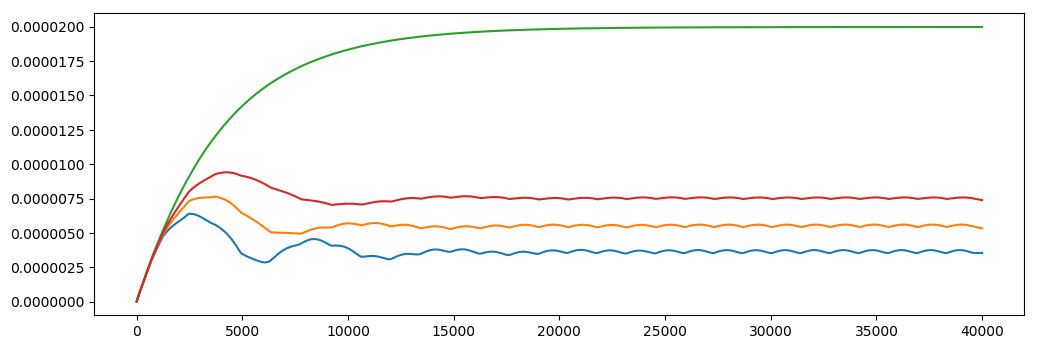

In [172]:
plt.plot(np.abs(c[0,:]))
plt.plot(np.abs(c[10,:]))
plt.plot(np.abs(c[50,:]))
plt.plot(np.abs(c[80,:]))

There seems to be some oscillations still in the amplitude of the field vector? I would expect these to be absent. 

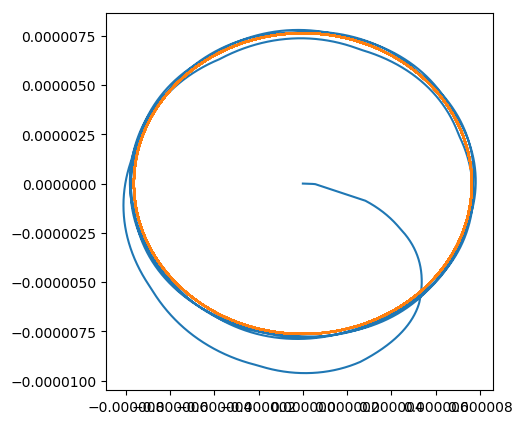

In [168]:
plt.figure(figsize=(5,5))
plt.plot(np.real(c[20,:]), np.imag(c[20,:]))
a=np.abs(c[20,-1])
ang = t/np.max(t)*360
plt.plot(a*np.cos(ang), a*np.sin(ang), '--')

At least it's going in a circle...but these wibbles are annoying.

Size of time vector: 4000
Integration time: 0.03 s


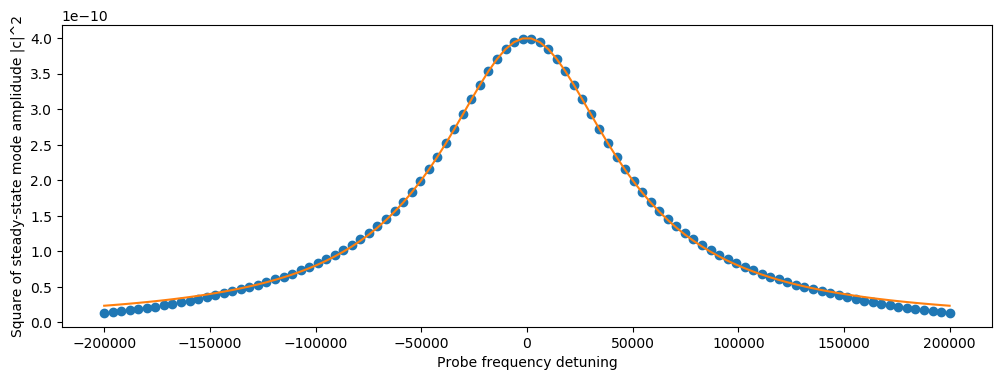

In [112]:
# Steady state is well represented by last 25% of the vector
c_ss = c[:,3*Nt//4:]

# Steady state amplitude is easy
c_max = np.average(np.abs(c_ss)**2, axis=1)
plt.plot(w, c_max, 'o', label="Numerical")
plt.plot(w, 1/(w**2+(kappa/2)**2), label="Lorentzian")
plt.ylabel("Square of steady-state mode amplidude |c|^2")
plt.xlabel("Probe frequency detuning")
plt.show()

Does this make sense? It seems to be pretty Lorentzian, except does poorly in the tails? Maybe soemthing to do with the wibbles? Something to investigate at some point. For now, I will move forward though.

Let's try now with a difference reference frame, for fun. Take `Delta_tilde = -3*kappa`:

In [ ]:
# Our input parameters
kappa = 100e3
Delta_tilde = -3*kappa

s_in_pr = 1 
N = 100
w = np.linspace(-2*kappa,2*kappa,N)

y0 = np.zeros(N)+0j

def dydt(t,y):
    return (1j*Delta_tilde-kappa/2)*y + s_in_pr*np.exp(1j*w*t)

dt = 1/max(w)/100

T = 20/kappa
t = np.arange(0,T,dt)
Nt = len(t)
print("Size of time vector: %d" % Nt)

t1 = time.time()
sol = solve_ivp(dydt, [0,T], y0, t_eval = t, method="BDF")
t2 = time.time()
print("Integration time: %.2f s" % (t2-t1))

c = sol.y

Let's check that c is behaving the way we think it should?

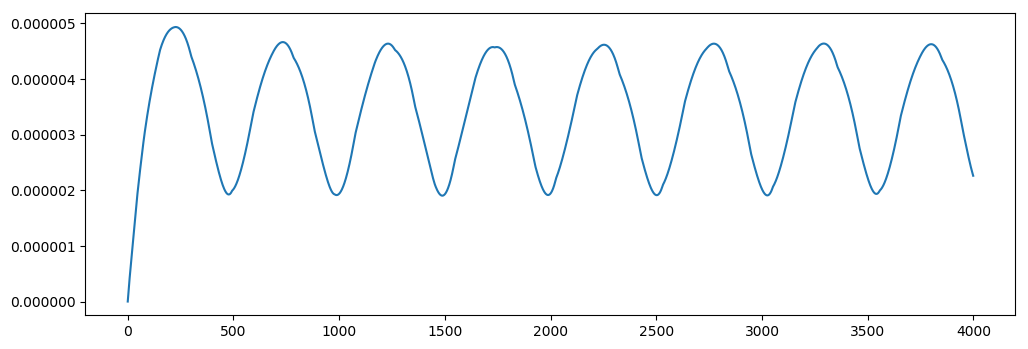

In [124]:
plt.plot(np.abs(c[50,:]))

Now the wibbles are really bad? Hmmm...

### Let's try full nonliner equations

In [ ]:
# Our input parameters
kappa = 100e3
Delta_tilde = 0